# _(Brunel & Hakim, 1999)_ Fast Global Oscillation

Implementation of the paper:

- Brunel, Nicolas, and Vincent Hakim. "Fast global oscillations in networks of integrate-and-fire neurons with low firing rates." Neural computation 11.7 (1999): 1621-1671.

In [2]:
import brainpy as bp
import numpy as np

bp.profile.set(jit=True)

In [3]:
Vr = 10.  # mV
theta = 20.  # mV
tau = 20.  # ms
delta = 2.  # ms
taurefr = 2.  # ms
duration = 100.  # ms
J = .1  # mV
muext = 25.  # mV
sigmaext = 1.  # mV
C = 1000
N = 5000
sparseness = float(C) / N

In [4]:
@bp.integrate
def int_v(V, t):
    return (-V + muext) / tau, sigmaext / np.sqrt(tau)


def neu_update(ST, _t):
    ST['spike'] = 0.
    ST['not_ref'] = 0.
    if (_t - ST['t_last_spike']) > taurefr:
        V = int_v(ST['V'], _t)
        if V > theta:
            ST['spike'] = 1.
            ST['V'] = Vr
            ST['t_last_spike'] = _t
        else:
            ST['V'] = V
            ST['not_ref'] = 1.


lif = bp.NeuType(name='lif',
                 ST=bp.NeuState('spike', V=Vr, t_last_spike=-1e7, not_ref=1.),
                 steps=neu_update,
                 mode='scalar')

In [5]:
def syn_update(ST, pre):
    if pre['spike']:
        ST['g'] = J
    else:
        ST['g'] = 0.


@bp.delayed
def syn_output(ST, post):
    if post['not_ref']:
        post['V'] -= ST['g']


syn = bp.SynType(name='syn', ST=bp.SynState(['g']),
                 steps=(syn_update, syn_output),
                 mode='scalar')

In [6]:
group = bp.NeuGroup(lif, geometry=N, monitors=['spike', 'V'])
conn = bp.SynConn(syn, pre_group=group, post_group=group,
                  conn=bp.connect.FixedProb(sparseness),
                  delay=delta)
net = bp.Network(group, conn)
net.run(duration, report=True)

Compilation used 0.6021 s.
Start running ...
Run 10.0% used 1.641 s.
Run 20.0% used 3.229 s.
Run 30.0% used 4.802 s.
Run 40.0% used 6.398 s.
Run 50.0% used 7.984 s.
Run 60.0% used 9.564 s.
Run 70.0% used 11.170 s.
Run 80.0% used 12.753 s.
Run 90.0% used 14.351 s.
Run 100.0% used 15.917 s.
Simulation is done in 15.917 s.


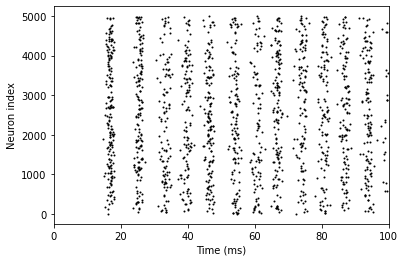

In [7]:
bp.visualize.raster_plot(net.ts, group.mon.spike, xlim=(0, duration), show=True)